# Basic usage of rocks

How to use <a href="https://rocks.readthedocs.io/en/latest/"><tt>rocks</tt></a> to easily access information on Solar System Objects (SSOs), from the <a href="https://ssp.imcce.fr/webservices/ssodnet/">Web service</a> of <a href="https://ssp.imcce.fr/forms/ssocard">SsODNet</a> (<a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract">Berthier et al., 2023)</a>. 
    
### Identification of bodies

In [1]:
import rocks

Define targets by their identification, either the IAU number, a designation (including packed designation), or the name. <tt>rocks</tt> deals with lower/upper cases, spaces, etc.

In [2]:
targets = [1, 234, "Pallas", "G!kun||'homdima", "6344 P-L", "J95X00A", "2000 CR105", "1999RQ36"]

In [3]:
name_num = rocks.id(targets)
print( name_num)

[('Ceres', 1), ('Barbara', 234), ('Pallas', 2), ("G!kun||'homdima", 229762), ('6344 P-L', nan), ('Biagiomarin', 24850), ('2000 CR105', 148209), ('Bennu', 101955)]


<br><br>
### Retrieve the best estimates for a given SSO from the ssoCard

See <a href="https://ssp.imcce.fr/webservices/ssodnet/api/ssocard">SsODNet/ssoCard documentation</a> and <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract">Berthier et al. (2023)</a> for a  complete description of how the best estimates are determined. See also <a href="https://rocks.readthedocs.io/en/latest/cli.html#getting-values"><tt>rocks</tt> documentation</a> for a full description of the python interface.

In [4]:
sso = rocks.Rock(1)

In [5]:
sso.number

1

In [6]:
sso.name

'Ceres'

In [7]:
sso.diameter.value

939.4

In [8]:
sso.diameter.error.min_, sso.diameter.error.max_

(-0.4, 0.4)

In [9]:
sso.mass.value

9.384e+20

In [10]:
sso.mass.error_

1e+17

To get the average uncertainty instead of the lower and upper 1 $\sigma$.

There is also a complete traceability of sources with a bibliography attached to each parameter:

In [11]:
sso.diameter.bibref

[Bibref(path='', doi='10.1126/science.aaf4219', year=2016, title='Dawn arrives at Ceres: Exploration of a small, volatile-rich world', bibcode='2016Sci...353.1008R', shortbib='Russell+2016')]

Putting things together:

In [12]:
print( 'Diameter of ({:d}) {:s}: {:.1f} +/- ({:.1f},{:.1f}) {:s} by {:s}'.format(
    sso.number, 
    sso.name, 
    sso.diameter.value, 
    sso.diameter.error.min_, 
    sso.diameter.error.max_, 
    sso.diameter.unit, 
    ';'.join(sso.diameter.bibref.shortbib)
))

Diameter of (1) Ceres: 939.4 +/- (-0.4,0.4) km by Russell+2016


<a href="https://ssp.imcce.fr/webservices/ssodnet/">SsODNet</a> and its <a href="https://rocks.readthedocs.io/en/latest/"><tt>rocks</tt><a/> interface proposes many parameters. See the <a href="https://ssp.imcce.fr/forms/ssocard/doc"><tt>ssoCard</tt> documentation<a/> for a complete list of available parameters, and
<a href="https://rocks.readthedocs.io/en/latest/appendix.html#parameter-names"><tt>rocks</tt> documentation</a> 
to see how to access them.

<br><br>
### Retrieve the best estimates for several SSO from the ssoCard

See <a href="https://ssp.imcce.fr/webservices/ssodnet/api/ssocard">SsODNet/ssoCard documentation</a> and <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract">Berthier et al. (2023)</a> for a  complete description of how the best estimates are determined. See also <a href="https://rocks.readthedocs.io/en/latest/cli.html#getting-values"><tt>rocks</tt> documentation</a> for a full description of the python interface.

In [13]:
import time
import numpy as np
import pandas as pd

Let's query multiple ssoCards at once, to speed up the process. They are downloaded asynchronously, and cached on disk. 

In [14]:
start = time.time()
ssos = rocks.rocks(targets)
print(f"This took {time.time() - start:.3} seconds.")

This took 0.323 seconds.


We will now organize the information into a <a href="https://pandas.pydata.org/">pandas</a> <a href="https://pandas.pydata.org/docs/reference/frame.html">DataFrame</a>.

In [15]:
data = pd.DataFrame(index=range(len(targets)))
for i in range(len(targets)):

    # Base identification - Always present in ssoCard
    data.loc[i,'num'] = ssos[i].number
    data.loc[i,'name'] = ssos[i].name

    # Osculating elements - Always present in ssoCard
    data.loc[i,'H'] = ssos[i].parameters.physical.absolute_magnitude.value
    data.loc[i,'a'] = ssos[i].parameters.dynamical.orbital_elements.semi_major_axis.value
    data.loc[i,'e'] = ssos[i].parameters.dynamical.orbital_elements.eccentricity.value
    data.loc[i,'i'] = ssos[i].parameters.dynamical.orbital_elements.inclination.value

    # Taxonomy - Only add values if present in the ssoCard
    if ssos[i].parameters.physical.taxonomy.class_.value!='':
        data.loc[i,"taxo_class"] = ssos[i].parameters.physical.taxonomy.class_.value
        data.loc[i,"taxo_complex"] = ssos[i].parameters.physical.taxonomy.complex.value
        data.loc[i,"taxo_scheme"] = ssos[i].parameters.physical.taxonomy.scheme.value
        data.loc[i,"taxo_method"] = ssos[i].parameters.physical.taxonomy.technique.value
        data.loc[i,"taxo_range"] = ssos[i].parameters.physical.taxonomy.waverange.value
        data.loc[i,"taxo_ref"] = ';'.join(ssos[i].parameters.physical.taxonomy.bibref.bibcode)

    # Diameter - Only add values if present in the ssoCard
    if ~np.isnan(ssos[i].parameters.physical.diameter.value):
        data.loc[i,"diameter"] = ssos[i].parameters.physical.diameter.value
        data.loc[i,"err_diameter"] = ssos[i].parameters.physical.diameter.error_
        data.loc[i,"err_diameter_low"] = ssos[i].parameters.physical.diameter.error.min_
        data.loc[i,"err_diameter_up"] = ssos[i].parameters.physical.diameter.error.max_
        data.loc[i,"diameter_method"] = ssos[i].parameters.physical.diameter.method[0].name
        data.loc[i,"diameter_ref"] = ';'.join(ssos[i].parameters.physical.diameter.bibref.bibcode)

In [16]:
data

,num,name,H,a,e,i,taxo_class,taxo_complex,taxo_scheme,taxo_method,taxo_range,taxo_ref,diameter,err_diameter,err_diameter_low,err_diameter_up,diameter_method,diameter_ref
0,1.0,Ceres,3.53,2.765778,0.078308,10.588056,C,C,Mahlke,Spec,VISNIR,2022A&A...665A..26M,939.400,0.400,-0.400,0.400,Rendez-vous with a spacecraft,2016Sci...353.1008R
1,234.0,Barbara,9.10,2.385990,0.245102,15.376034,L,L,Mahlke,Spec,VISNIR,2022A&A...665A..26M,46.300,5.000,-5.000,5.000,"Knitted Occultation, Adaptive-optics, and Ligh...",2015MNRAS.448.3382T
2,2.0,Pallas,4.21,2.774374,0.229701,34.874936,B,B,Mahlke,Spec,VISNIR,2022A&A...665A..26M,512.588,5.336,-5.336,5.336,All-Data Asteroid Model,2021A&A...654A..56V;2010Icar..205..460C;2020Na...
3,229762.0,G!kun||'homdima,3.55,73.043150,0.485505,23.389756,NaN,NaN,NaN,NaN,NaN,NaN,609.678,15.912,-15.912,15.912,Stellar Occultation,2019pdss.data....3H
4,NaN,6344 P-L,20.39,2.819759,0.661693,4.677970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,24850.0,Biagiomarin,15.54,2.327591,0.129860,5.726330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,148209.0,2000 CR105,6.30,215.583201,0.795903,22.824297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,101955.0,Bennu,20.90,1.125915,0.203610,6.034316,B,B,Mahlke,Spec,VISNIR,2022A&A...665A..26M,0.492,0.020,-0.020,0.020,Radar shape modeling,2013Icar..226..629N


<br><br>
### Retrieve all estimates from the literature for a given SSO from the datacloud


See <a href="https://ssp.imcce.fr/webservices/ssodnet/api/datacloud">SsODNet/datacloud documentation</a> and <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract">Berthier et al. (2023)</a> for a  complete description of which parameters are included in the datacloud. See also <a href="https://rocks.readthedocs.io/en/latest/cli.html#getting-values"><tt>rocks</tt> documentation</a> for a full description of the python interface.

Let's retrieve all diameter and albedo measurements of Vesta. The datacloud collections are stored as <a href="https://pandas.pydata.org/">pandas</a> <a href="https://pandas.pydata.org/docs/reference/frame.html">DataFrame</a> in <tt>rocks</tt>:

In [17]:
vesta = rocks.Rock(4, datacloud="diamalbedo")
vesta.diamalbedo

,link,title,shortbib,datasetname,idcollection,resourcename,bibcode,doi,year,id_,...,err_albedo_down,beaming,err_beaming,emissivity,err_emissivity,selection,method,preferred_albedo,preferred_diameter,preferred
0,,Diameter and albedo estimates,Tedesco+2002a,,None,,2002AJ....123.1056T,,2002,198116,...,-0.053,NaN,NaN,NaN,NaN,None,STM,False,False,False
1,,Diameter and albedo estimates,Herald+2019,,None,,2019pdss.data....3H,,2019,198117,...,NaN,NaN,NaN,NaN,NaN,None,OCC,False,False,False
2,,Diameter and albedo estimates,Drummond+1998,,None,,1998Icar..132...80D,,1998,198118,...,NaN,NaN,NaN,NaN,NaN,None,TE-IM,False,False,False
3,,Diameter and albedo estimates,Drummond+2008,,None,,2008Icar..197..480D,,2008,198119,...,NaN,NaN,NaN,NaN,NaN,None,TE-IM,False,True,True
4,,Diameter and albedo estimates,Ryan+2010,,None,,2010AJ....140..933R,,2010,198120,...,-0.026,0.842,0.039,NaN,NaN,None,NEATM,False,False,False
5,,Diameter and albedo estimates,Alí-Lagoa+2020,,None,,2020A&A...638A..84A,,2020,198121,...,NaN,NaN,NaN,0.90,NaN,None,TPM,False,False,False
6,,Diameter and albedo estimates,Alí-Lagoa+2020,,None,,2020A&A...638A..84A,,2020,198122,...,NaN,NaN,NaN,0.90,NaN,None,TPM,False,False,False
7,,Diameter and albedo estimates,Ryan+2010,,None,,2010AJ....140..933R,,2010,198123,...,-0.012,NaN,NaN,NaN,NaN,None,STM,False,False,False
8,,Diameter and albedo estimates,Usui+2011,,None,,2011PASJ...63.1117U,,2011,198124,...,-0.013,NaN,NaN,NaN,NaN,None,NEATM,False,False,False
9,,Diameter and albedo estimates,Herald+2019,,None,,2019pdss.data....3H,,2019,198125,...,NaN,NaN,NaN,NaN,NaN,None,OCC,False,False,False


The best estimates provided in the ssoCard are based on these collections. The datacloud entries in <tt>rocks</tt> have a <kbd>preferred</kbd> attributes, which are lists containing <kbd>True</kbd> if the corresponding observation is preferred, and <kbd>False</kbd> otherwise. 

We refer to <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract">Berthier et al. (2023)</a> for an extensive description of the selection of preferred entries. 

In [18]:
ceres = rocks.Rock(1, datacloud='masses')
print("Number of mass estimates for Ceres: ", len(ceres.masses.mass))

Number of mass estimates for Ceres:  40


In [19]:
for i, obs in ceres.masses.iterrows(): 
  mean_error = (obs.err_mass_up + abs(obs.err_mass_down)) / 2
  print(f"[{'X' if obs.preferred else ' '}] {obs.mass:.3e} +- {mean_error:.2e} [{obs.shortbib}, Method: {obs.method}]")

[ ] 8.270e+20 +- 3.78e+19 [Kuzmanoski+1996, Method: DEFLECT]
[ ] 8.730e+20 +- 7.96e+18 [Hilton+1999, Method: DEFLECT]
[ ] 9.040e+20 +- 1.39e+19 [Kova+2012, Method: DEFLECT]
[ ] 9.190e+20 +- 1.41e+19 [Sitarski+1995, Method: DEFLECT]
[ ] 9.290e+20 +- 1.79e+19 [Carpino+1996, Method: DEFLECT]
[ ] 9.290e+20 +- 3.68e+18 [Fienga+2013, Method: EPHEM]
[ ] 9.290e+20 +- 3.84e+18 [Fienga+2014, Method: EPHEM]
[ ] 9.310e+20 +- 6.46e+18 [Konopliv+2011, Method: EPHEM]
[ ] 9.320e+20 +- 9.32e+19 [Folkner+2009, Method: EPHEM]
[ ] 9.348e+20 +- 5.97e+19 [Goffin1991, Method: DEFLECT]
[ ] 9.350e+20 +- 5.57e+18 [Konopliv+2006, Method: DEFLECT]
[ ] 9.350e+20 +- 5.97e+19 [Goffin+2001, Method: DEFLECT]
[ ] 9.350e+20 +- 7.96e+18 [Michalak+2000, Method: DEFLECT]
[ ] 9.383e+20 +- 2.29e+18 [Fienga+2019, Method: EPHEM]
[X] 9.384e+20 +- 1.00e+17 [Russell+2016, Method: SPACE]
[ ] 9.380e+20 +- 2.21e+18 [Viswanathan+2017, Method: EPHEM]
[ ] 9.394e+20 +- 1.31e+18 [Baer+2017, Method: DEFLEC]
[ ] 9.390e+20 +- 1.57e+18 [Pitj

<br><br>
### Retrieve all best estimates for all SSOs with the BFT


We store all estimates for all SSOS in a large tabular file, see <a href="https://ssp.imcce.fr/webservices/ssodnet/api/bft">SsODNet/bft documentation</a> and <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract">Berthier et al. (2023)</a>.

We will download it and open it

In [20]:
import wget
import os

In [21]:
bft_url = 'https://ssp.imcce.fr/data/ssoBFT-latest.parquet'

if not os.path.isfile( 'ssoBFT-latest.parquet' ):
    wget.download(bft_url)

In [22]:
bft = pd.read_parquet('ssoBFT-latest.parquet' )

In [23]:
bft

,sso_id,sso_number,sso_name,sso_type,sso_class,ssocard,orbital_elements.ref_epoch,orbital_elements.number_observation,orbital_elements.orbital_arc,orbital_elements.ceu.value,...,spins.4.DEC0.value,spins.4.DEC0.error.min,spins.4.DEC0.error.max,spins.4.long.value,spins.4.long.error.min,spins.4.long.error.max,spins.4.lat.value,spins.4.lat.error.min,spins.4.lat.error.max,spins.4.technique
0,Algirdas,202092.0,Algirdas,Asteroid,MB>Middle,/work/ssodnet/ssoCard-20230228/store/0001/Algi...,2459300.5,136,10453.0,0.081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,Deronda,201777.0,Deronda,Asteroid,MB>Outer,/work/ssodnet/ssoCard-20230228/store/0001/Dero...,2459300.5,397,6264.0,0.045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,Jogaila,202093.0,Jogaila,Asteroid,MB>Middle,/work/ssodnet/ssoCard-20230228/store/0001/Joga...,NaN,359,7305.0,0.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,Marcelroche,201497.0,Marcelroche,Asteroid,MB>Middle,/work/ssodnet/ssoCard-20230228/store/0001/Marc...,2459300.5,728,7875.0,0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,Steinhardt,201751.0,Steinhardt,Asteroid,MB>Middle,/work/ssodnet/ssoCard-20230228/store/0001/Stei...,2459300.5,294,6054.0,0.052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266834,9608_P-L,85057.0,9608 P-L,Asteroid,MB>Outer,/work/ssodnet/ssoCard-20230228/store/0127/9608...,2459300.5,1341,21876.0,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1266835,9609_P-L,24569.0,9609 P-L,Asteroid,MB>Inner,/work/ssodnet/ssoCard-20230228/store/0127/9609...,2459300.5,1247,21759.0,0.032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1266836,9611_P-L,26034.0,9611 P-L,Asteroid,MB>Middle,/work/ssodnet/ssoCard-20230228/store/0127/9611...,2459300.5,1507,22032.0,0.021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1266837,9613_P-L,117971.0,9613 P-L,Asteroid,MB>Middle,/work/ssodnet/ssoCard-20230228/store/0127/9613...,2459300.5,620,21986.0,0.019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


Yes, it is as easy as that :-)
<br><br>

You can make selection in that large corpus of data, e.g., just the inner belt:

In [24]:
imb = bft['sso_class'] == 'MB>Inner'
print( 'Selected {:,d} inner belt asteroids out of {:,d} SSOs'.format(len(bft[imb]), len(bft)) )

Selected 318,162 inner belt asteroids out of 1,266,839 SSOs


Or more complex selection, based on any combination of columns:

In [25]:
pristine = (bft['orbital_elements.semi_major_axis.value']>2.82) & \
           (bft['orbital_elements.semi_major_axis.value']<2.96)& \
           (bft['orbital_elements.inclination.value']<5)

In [26]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Inclination / deg.')

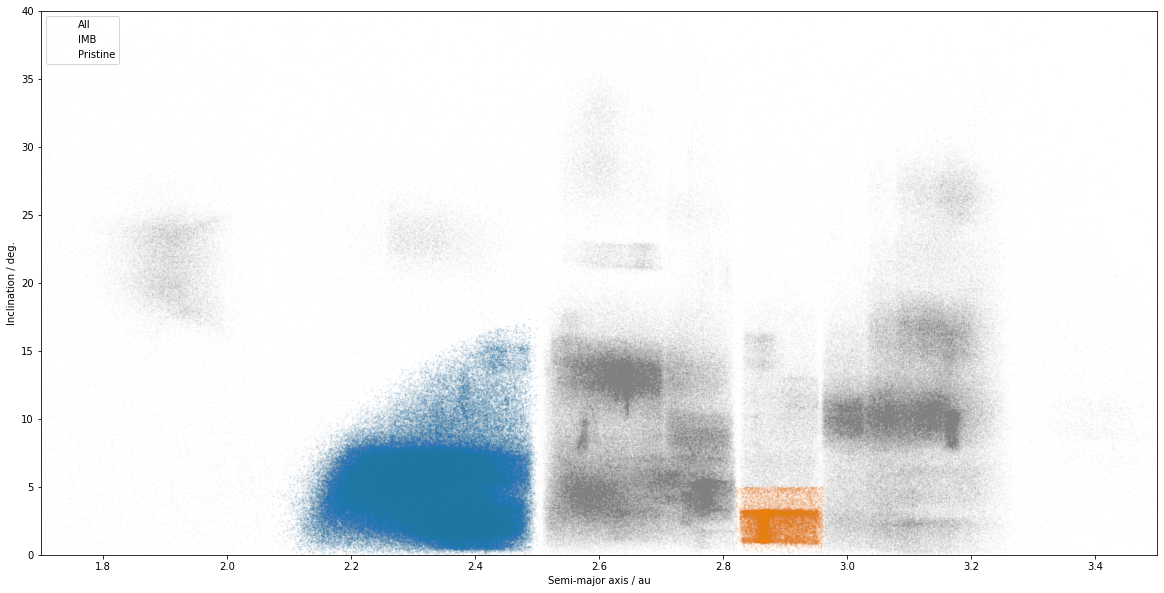

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

# Plot all objects
ax.scatter( bft['orbital_elements.semi_major_axis.value'],
            bft['orbital_elements.inclination.value'],
            color='gray', s=1, alpha=0.015, rasterized=True, label='All' )

# Only the inner belt
ax.scatter( bft.loc[imb, 'orbital_elements.semi_major_axis.value'],
            bft.loc[imb, 'orbital_elements.inclination.value'],
            s=1, alpha=0.05, rasterized=True, label='IMB' )

# Only the low-inclination of the pristine part of the belt  
ax.scatter( bft.loc[pristine, 'orbital_elements.semi_major_axis.value'],
            bft.loc[pristine, 'orbital_elements.inclination.value'],
            s=1, alpha=0.05, rasterized=True, label='Pristine' )

# Set the axes
ax.legend(loc='upper left')
ax.set_xlim(1.7,3.5)
ax.set_ylim(0,40)
ax.set_xlabel('Semi-major axis / au')
ax.set_ylabel('Inclination / deg.')
